Importing necessary data

In [138]:
import tweepy
import csv
import time
import pandas as pd
import re
from pymongo import MongoClient
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter as DF

Identify keywords related to AI 

In [2]:
ai_keywords = [
    "NLP", 
    "AI", 
    "Artificial Intelligence", 
    "Chatgpt", 
    "Deepseek", 
    "CV"
]

# Data Extraction

Requsting tweets using tweepy

In [3]:
bearer_token = r"AAAAAAAAAAAAAAAAAAAAAHwn0wEAAAAA%2BXtWl8lg1EhNvP3aIdbuvW2WOCc%3Dw8DzG3cOB9diVNKfi5qUvMHTjZ42lzmHvDXnjob4Jbq8vPuVW3"

In [4]:
client = tweepy.Client(bearer_token= bearer_token)

Reading tweets

In [ ]:
with open("ai_tweets.csv", 'a', newline='', encoding='utf-8-sig') as file:  # creating csv file
    writer= csv.writer(file)
    writer.writerow(['Tweet', 'created_at'])
    
    for keyword in ai_keywords:
        try: # Requesting tweets based on keywords (English tweets)
            tweets = client.search_recent_tweets(
                query = f' "{keyword}" lang:en -is:retweet', 
                max_results = 10,
                tweet_fields =['created_at', 'text']  # I requset the text and the date the tweets created at
            )
            
            if tweets.data:  #Store tweets in the csv file
                for tweet in tweets.data:
                    writer.writerow([tweet.text, tweet.created_at,])
            time.sleep(10)
            
        except Exception as e:
            print(f'Error fetching for {keyword} : ', e)

Error fetching for NLP :  429 Too Many Requests
Too Many Requests
Error fetching for AI :  429 Too Many Requests
Too Many Requests
Error fetching for Artificial Intelligence :  429 Too Many Requests
Too Many Requests
Error fetching for Chatgpt :  429 Too Many Requests
Too Many Requests
Error fetching for Deepseek :  429 Too Many Requests
Too Many Requests
Error fetching for CV :  429 Too Many Requests
Too Many Requests


Reading dataset

In [94]:
df = pd.read_csv("ai_tweets.csv", encoding='ISO-8859-1')
print(f"Total rows: {len(df)}")


Total rows: 151676


-----------------

# Cleaning

In [95]:
df = df[~df['created_at'].astype(str).str.contains("Time", na=False)]
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df[df['created_at'].notna()]

df.drop_duplicates(inplace=True)

df.dropna(subset=['Tweet', 'created_at'], inplace=True)


In [96]:
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"@\w+", "", text)    
    text = re.sub(r"#\w+", "", text)     
    text = re.sub(r"[^\w\s]", "", text)  
    text = re.sub(r"\s+", " ", text)     
    return text.strip().lower()

In [97]:
df['cleaned_text'] = df['Tweet'].apply(clean_text)
df.drop_duplicates(subset=['cleaned_text'], inplace=True)

df['Tweet'] = df['cleaned_text']
df.drop(columns=['cleaned_text'], inplace=True)

df.head()

,Tweet,created_at
0,invest in a currency that is designed to offer...,2025-03-14
1,while having all the hope around chatgpt lets ...,2025-03-14
2,join the movement towards a more sustainable a...,2025-03-14
3,theres a snowstorm out so naturally i decided ...,2025-03-14
4,invest in a currency that offers a more secure...,2025-03-14


In [98]:
df.shape

(123746, 2)

In [99]:
na_counts = df.isna().sum()
print(na_counts)

Tweet         0
created_at    0
dtype: int64


In [100]:
duplicate_counts = df.duplicated().sum()
duplicate_counts

0

Storing data to MongoDB after cleaning

In [ ]:
client = MongoClient('mongodb://localhost:27017/')  
db = client['ai_tweets_db']  
collection = db['tweets']  
data_dict = df.to_dict("records")
#   checking if the data already exists
if collection.count_documents({}) == 0:
    collection.insert_many(data_dict)
    print("The data has been stored in MongoDB.")
else:
    print("Data already exists in MongoDB. Skipping insert.")

The data has been stored in MongoDB


Displaying number of docs

In [108]:
count = collection.count_documents({})
print(f"num. of docs.: {count}")

num. of docs.: 123746


-------------

# Sentiment analysis

In [87]:
# loading data From MogoDB to DataFrame
df = pd.DataFrame(list(collection.find()))

In [88]:
if '_id' in df.columns: #removing ID column since it will cause an issue 
    df.drop(columns=['_id'], inplace=True)

In [89]:
vader = SentimentIntensityAnalyzer() #Initialize VADER

Functions for sentiment

In [90]:
def analyze_vader(txt):
    score = vader.polarity_scores(txt)
    return score['compound']

In [91]:
def analyze_textblob(txt):
    return TextBlob(txt).sentiment.polarity

Apply sentiment analysis

In [102]:
df['vader_score'] = df['Tweet'].apply(analyze_vader)
df['textblob_score'] = df['Tweet'].apply(analyze_textblob)

In [103]:
df.head(20)

,Tweet,created_at,vader_score,textblob_score
0,invest in a currency that is designed to offer...,2025-03-14,0.5994,0.166667
1,while having all the hope around chatgpt lets ...,2025-03-14,0.5523,-0.125000
2,join the movement towards a more sustainable a...,2025-03-14,0.7479,0.233333
3,theres a snowstorm out so naturally i decided ...,2025-03-14,0.0000,0.100000
4,invest in a currency that offers a more secure...,2025-03-14,0.4005,0.250000
5,robots will take over the world ððð,2025-03-14,0.0000,0.000000
6,join the community of investors who are commit...,2025-03-14,0.5106,0.000000
7,âready to start saving lots of time with â max...,2025-03-14,0.7003,0.400000
8,not sure if wrote this articleâ,2025-03-14,-0.2411,-0.250000
9,news alert,2025-03-14,0.2960,0.000000


In [104]:
df.tail(20) 

,Tweet,created_at,vader_score,textblob_score
151618,deepseek said something that made me feel like...,2025-04-19,0.1901,-0.400000
151619,chatgpt helped me with my homework and now iâm...,2025-02-16,-0.1027,0.000000
151620,deepseek told me the truth i wasnât ready to h...,2025-04-15,0.7717,0.200000
151621,chatgpt is too good at answering questions is ...,2025-03-16,0.4404,0.150000
151622,deepseekâs out here changing my life with pred...,2025-02-05,0.0000,0.000000
151623,chatgpt helped me plan my life but iâm still w...,2025-03-28,0.5499,0.000000
151624,deepseek saw my mistakes before i did itâs hon...,2025-03-12,-0.4385,0.800000
151625,chatgpt just made me realize iâve been living ...,2025-03-31,0.0000,0.000000
151626,deepseek knows more about trends than i do iâm...,2025-02-09,0.0000,0.500000
151627,chatgpt is basically a walking talking brain i...,2025-03-30,0.4019,0.000000


Add sentiment labels ('Positive', 'Neutral', 'Negative')

In [ ]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    
    elif score <= -0.05:
        return 'Negative'
    
    else: 
        return 'Neutral'

In [107]:
df['sentiment'] = df['vader_score'].apply(label_sentiment)
df.drop(columns=['textblob_score'], inplace=True)
df.head()

,Tweet,created_at,vader_score,sentiment
0,invest in a currency that is designed to offer...,2025-03-14,0.5994,Positive
1,while having all the hope around chatgpt lets ...,2025-03-14,0.5523,Positive
2,join the movement towards a more sustainable a...,2025-03-14,0.7479,Positive
3,theres a snowstorm out so naturally i decided ...,2025-03-14,0.0000,Neutral
4,invest in a currency that offers a more secure...,2025-03-14,0.4005,Positive


Store back to MongoDB

In [109]:
collection.drop() # drop old collection to avoid duplicates
collection.insert_many(df.to_dict('records'))
print('Add & Saved to MogoDB')

Add & Saved to MogoDB


------------

Comparing the average NLP & CV Sentiment

In [110]:
nlp_keywords = ['NLP', 'Natural Language Processing', 'Text', 'Language model']
cv_keywords = ['Computer Vision', 'Image', 'YOLO', 'ResNet', 'Object detection']

In [ ]:
#Filter NLP & CV tweets
nlp_tweets = df[df['Tweet'].str.contains('|'.join(nlp_keywords), case=False, na=False)]
cv_tweets = df[df['Tweet'].str.contains('|'.join(cv_keywords), case=False, na=False)]

In [118]:
print(f'NLP: {nlp_tweets.shape}')
print(f'CV: {cv_tweets.shape}')

NLP: (4011, 4)
CV: (1280, 4)


In [ ]:
#Compute average sentiment for both NLP & CV
avg_nlp_sentiment  = label_sentiment(nlp_tweets['vader_score'].mean())
avg_cv_sentiment = label_sentiment(cv_tweets['vader_score'].mean())

In [ ]:
#Compute the most common sentiment 
common_nlp_sentiment = df['sentiment'].mode()[0]
common_cv_sentiment = df['sentiment'].mode()[0]

In [ ]:
#Sentiment counts
nlp_sentiment  = nlp_tweets['sentiment'].value_counts().to_dict()
cv_sentiment = cv_tweets['sentiment'].value_counts().to_dict()

In [ ]:
# Storing results in DataFrame for later visualization
data = {
    'Metric': ['Average Sentiment', 'Most Common Sentiment', 'Positive Tweets Counts', 'Neutral Tweets Counts', 'Negative Tweets Counts' , 'No tweets'],
    'NLP': [avg_nlp_sentiment, common_nlp_sentiment, nlp_sentiment['Positive'], nlp_sentiment['Neutral'], nlp_sentiment['Negative'], len(nlp_tweets)],
    'CV': [avg_cv_sentiment, common_cv_sentiment, cv_sentiment['Positive'], cv_sentiment['Neutral'], cv_sentiment['Negative'], len(cv_tweets)]
}

npl_cv_df = pd.DataFrame(data)
npl_cv_df

,Metric,NLP,CV
0,Average Sentiment,Positive,Positive
1,Most Common Sentiment,Positive,Positive
2,Positive Tweets Counts,2699,838
3,Neutral Tweets Counts,838,324
4,Negative Tweets Counts,474,118
5,No tweets,4011,1280


----

Analyze sentiment upon specific events

In [134]:
events = {
    'ChatGPT Homework surge': {'Start_Date': '2025-02-12', 'End_Date': '2025-02-18', "keyword": ['ChatGPT', 'homework']},
    'AI Crypto Hype': {'Start_Date': '2025-03-12', 'End_Date': '2025-03-16', 'keyword': ["invest", "crypto", "AI"]}
}

In [135]:
def analyze_events(event_name, start_date, end_date, keywords):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    #Filter tweets by date and key words
    event_tweets = df[(df['created_at'] >= start) & 
                      (df['created_at'] <= end) & 
                      df['Tweet'].str.contains('|'.join(keywords), case= False, na=False)]
    
    # Calculate metrics 
    avg_sentiment = event_tweets['vader_score'].mean()
    sentiment_counts = event_tweets['sentiment'].value_counts().to_dict()
    
    return{
         "Event": event_name,
        "Avg_Sentiment": avg_sentiment,
        "Sentiment_Label": label_sentiment(avg_sentiment),
        "Positive_Tweets": sentiment_counts.get('Positive', 0),
        "Neutral_Tweets": sentiment_counts.get('Neutral', 0),
        "Negative_Tweets": sentiment_counts.get('Negative', 0),
        "Total_Tweets": len(event_tweets)
    }

In [136]:
result = []
for event_name, details in events.items():
    result.append(analyze_events(
        event_name,
        details['Start_Date'],
        details['End_Date'],
        details['keyword']
    ))

In [137]:
result_df = pd.DataFrame(result)
result_df

,Event,Avg_Sentiment,Sentiment_Label,Positive_Tweets,Neutral_Tweets,Negative_Tweets,Total_Tweets
0,ChatGPT Homework surge,0.220359,Positive,1874,933,552,3359
1,AI Crypto Hype,0.277149,Positive,2707,1217,543,4467


--------------

Temporal analysis Analysis

Collect tweets upon days & weeks

In [149]:
filtered_df = df[df['created_at'] >= '2025-02-15']

In [154]:
daily_tweets = filtered_df.groupby(pd.Grouper(key='created_at', freq='D')).agg({
    'Tweet': 'count', # no tweets 
    'vader_score': 'mean'  # sentiment avg 
})
daily_tweets.head()

,Tweet,vader_score
created_at,,
2025-02-15,3440,0.205029
2025-02-16,5041,0.208978
2025-02-17,5162,0.205134
2025-02-18,3569,0.215383
2025-02-19,3638,0.223335


In [155]:
weekly_tweets = filtered_df.groupby(pd.Grouper(key='created_at', freq='W-MON')).agg({
    'Tweet': 'count',          
    'vader_score': 'mean'
  })
weekly_tweets.head()

,Tweet,vader_score
created_at,,
2025-02-17,13643,0.206528
2025-02-24,29954,0.229504
2025-03-03,32124,0.264499
2025-03-10,32443,0.214789
2025-03-17,15499,0.233527


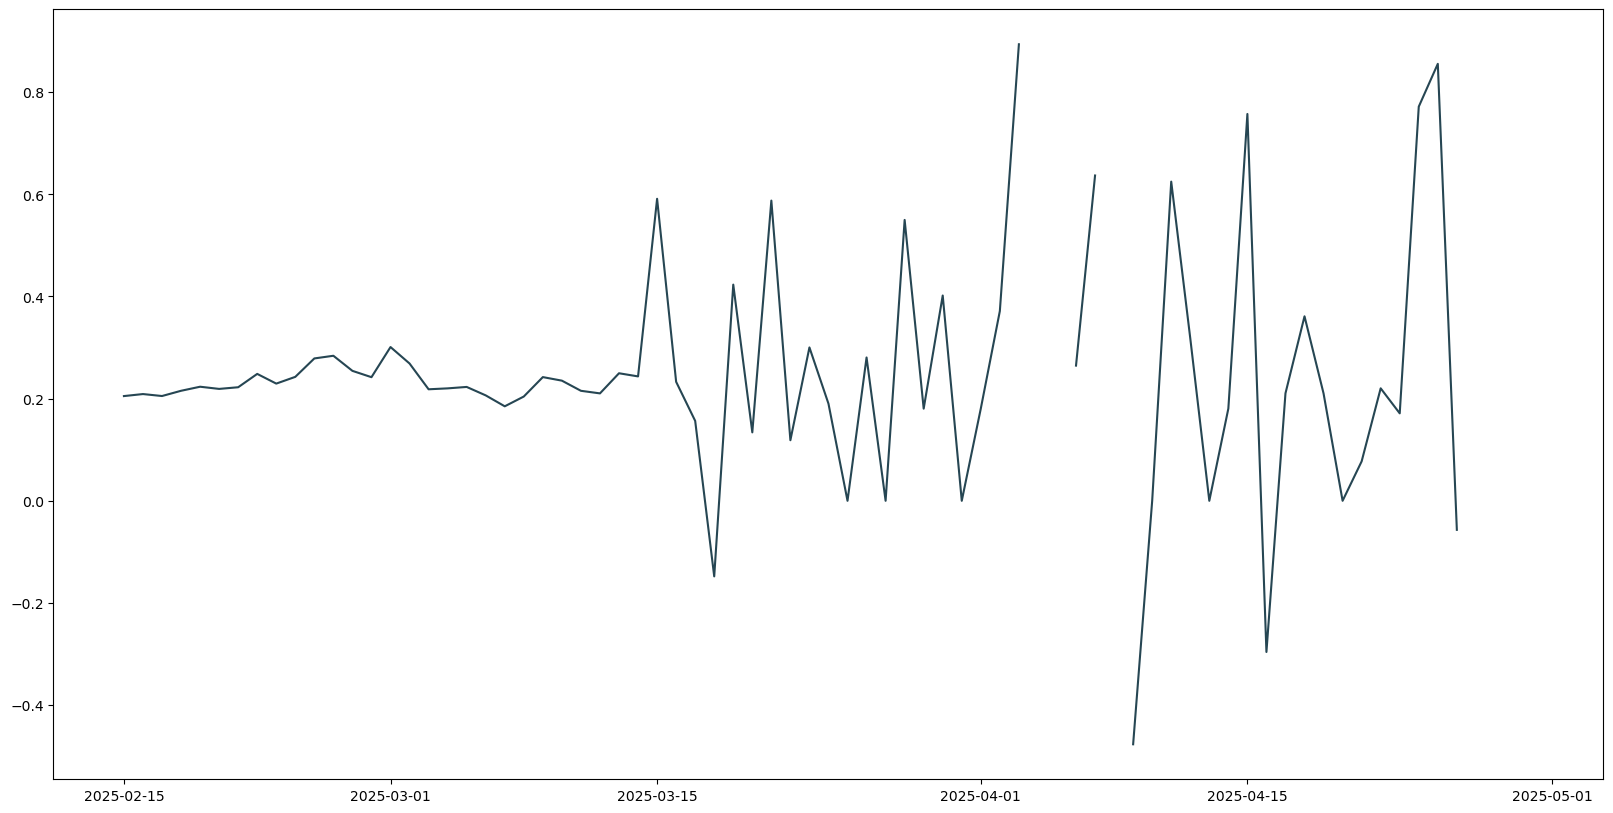

In [152]:
plt.figure(figsize=(20, 10))
plt.plot(daily_tweets.index, daily_tweets['vader_score'], color='#264653', label='Daily Sentiment')
plt.show()

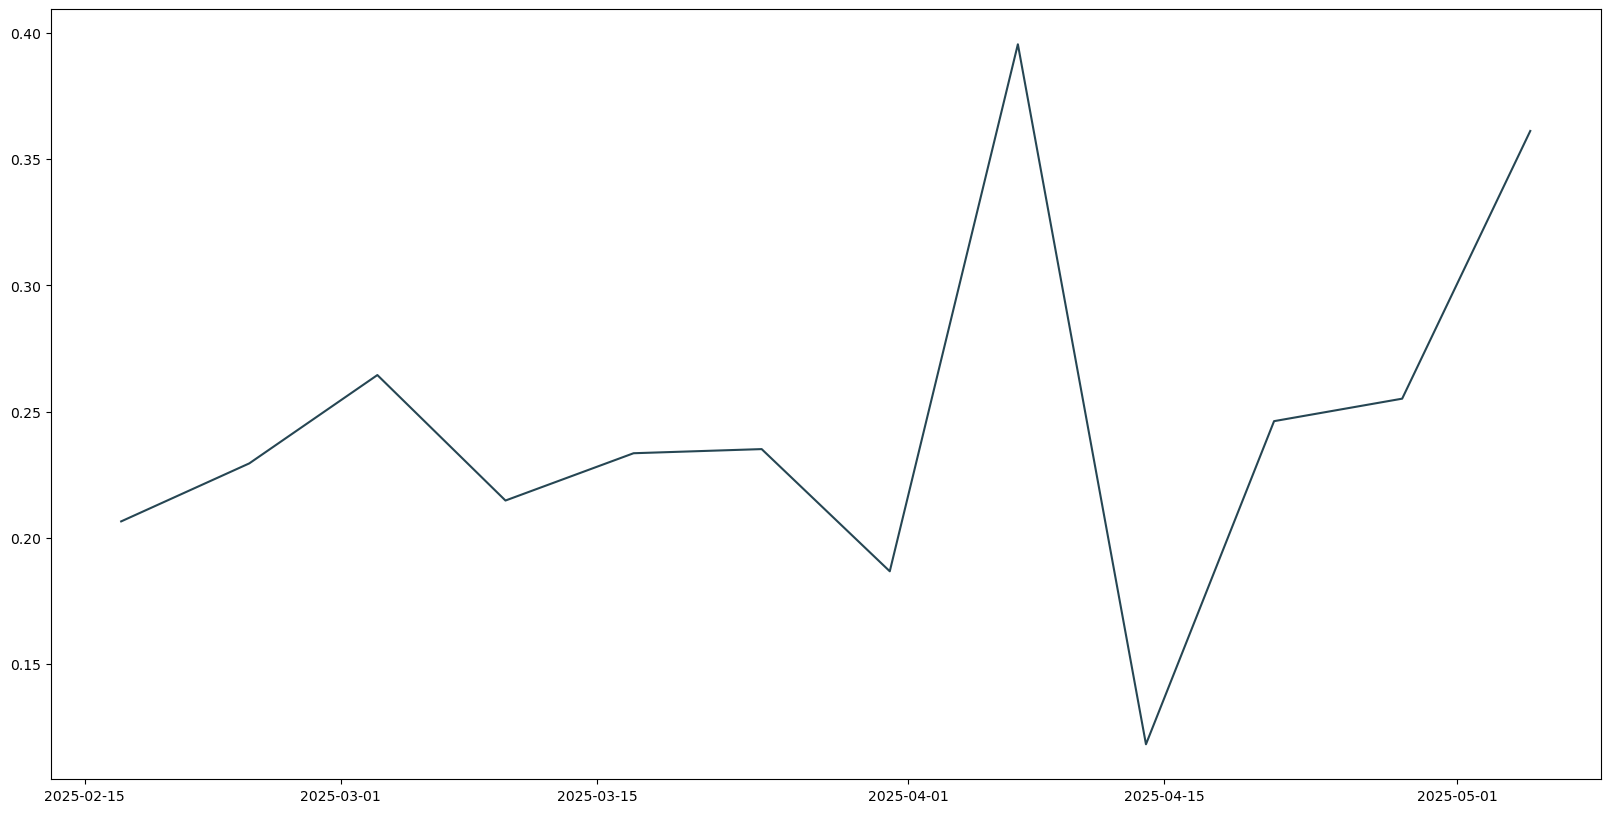

In [153]:
plt.figure(figsize=(20, 10))
plt.plot(weekly_tweets.index, weekly_tweets['vader_score'], color='#264653', label='Daily Sentiment')
plt.show()